<a href="https://colab.research.google.com/github/hukim1112/one-day-LLM-FT/blob/main/peft_lora_clm_with_additional_tokens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets evaluate transformers[sentencepiece] transformers[torch]
!pip install pip install accelerate -U
!pip install peft
!pip install dataclass_csv
!pip install huggingface_hub

우리는 lora를 huggingface에 업로드할 것 입니다. write 권한의 access token을 생성합니다.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

# Training PEFT models with new tokens being added to the embedding layers and tokenizer


이번 예시에서, 우리는 새로운 토큰들을 토크나이저와 모델에 추가할 때, LoRA 모델을 학습하는 방법을 배웁니다.

다음과 같은 상황에서 흔히 사용됩니다.

1. Instruction finetuning: 대화를 올바르게 포맷하기 위해 "<|user|>", "<|assistant|>", "<|system|>"와 같은 새로운 토큰이 추가되는 경우

2. 특정 언어에 대한 미세 조정: 한국어 데이터셋에서 LLM을 미세 조정하기 위해 한국어 토큰이 어휘에 추가되는 등 특정 언어에 대한 미세 조정

3. 에이전트로 동작을 가능하게 하기 위해 특정 형식으로 출력을 반환하도록 하는 Instruction finetuning: <|FUNCTIONS|>, <|BROWSE|>, <|TEXT2IMAGE|>, <|ASR|>, <|TTS|>, <|GENERATECODE|>, <|RAG|> 와 같은 새로운 토큰이 사용되는 경우

이러한 경우 LORA target_modules에 임베딩 모듈을 추가합니다. PEFT는 새로 추가된 토큰의 임베딩 가중치에 대한 특정 초기화 조건에 대해 훈련된 어댑터 가중치와 함께 새로 추가된 토큰의 임베딩 레이어를 저장합니다.

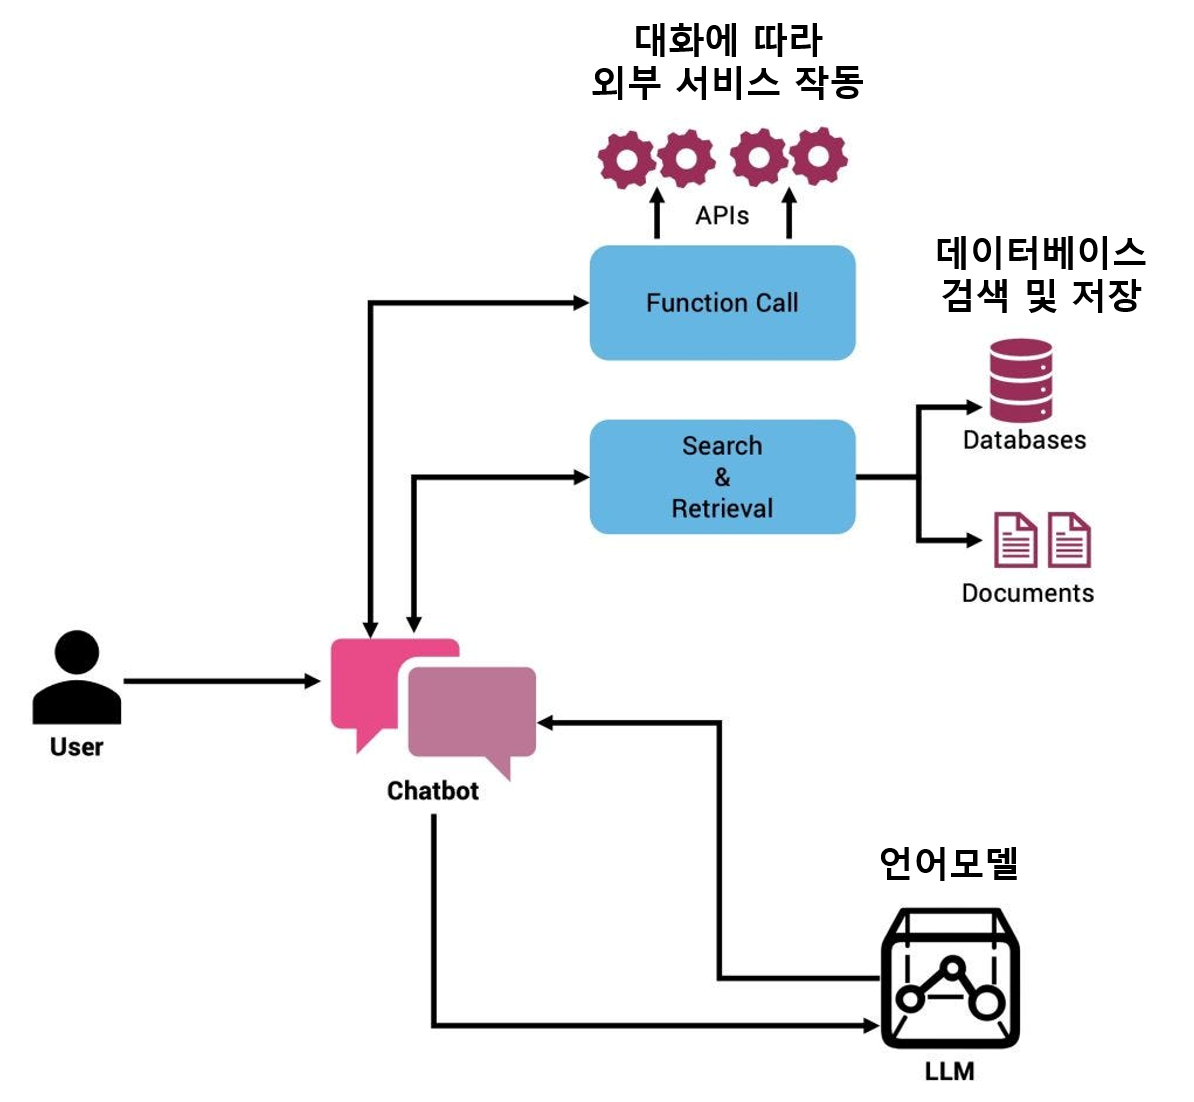

필요한 라이브러리를 가져옵니다.

In [ ]:
!nvidia-smi

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_PROJECT"] = "PeftExamples"
import transformers
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoModelForCausalLM, #사용자 입력에 기반하여 다음 단어를 예측하는 문제
    AutoTokenizer,
    HfArgumentParser,
    TrainingArguments,
    Trainer,
    default_data_collator,
)
import torch
from dataclasses import dataclass, field
from typing import Optional
from dataclass_csv import DataclassReader
from torch.utils.data import Dataset, DataLoader

from enum import Enum

## Prepare Model and Tokenizer

이제 기존의 패드(pad), 시작(bos), 끝(eos) 토큰을 교체하는 것과 더불어 27개의 새로운 토큰을 추가할 것입니다.

In [ ]:
class SpecialTokens(str, Enum):
    begin_target = "<|begintarget|>"
    end_target = "<|endtarget|>"
    begin_context = "<|begincontext|>"
    end_context = "<|endcontext|>"
    system = "<|system|>"
    user = "<|user|>"
    begin_last_user_utterance = "<|beginlastuserutterance|>"
    end_last_user_utterance = "<|endlastuserutterance|>"
    begin_dsts = "<|begindsts|>"
    end_dsts = "<|enddsts|>"
    begin_dst = "<|begindst|>"
    end_dst = "<|enddst|>"
    begin_belief = "<|beginbelief|>"
    end_belief = "<|endbelief|>"
    begin_response = "<|beginresponse|>"
    end_response = "<|endresponse|>"
    begin_action = "<|beginaction|>"
    end_action = "<|endaction|>"
    begin_user_action = "<|beginuseraction|>"
    end_user_action = "<|enduseraction|>"
    sys_actions = "<|sysactions|>"
    begin_intent = "<|beginintent|>"
    end_intent = "<|endintent|>"
    begin_requested_slots = "<|beginrequestedslots|>"
    end_requested_slots = "<|endrequestedslots|>"
    pad_token = "<|pad|>"
    bos_token = "<|startoftext|>"

    @classmethod
    def list(cls):
        return [c.value for c in cls]

Mistral-7B 모델을 미세조정 (finetune)할 것입니다. 우선 토크나이저를 불러와서 특수 토큰을 추가한 다음, 기본 모델을 불러오고 새로 추가된 토큰을 수용할 수 있도록 임베딩 레이어의 크기를 조정하겠습니다. 권한 문제가 발생했다면, 에러메시지의 링크를 타고 들어가 huggingface에서 Mistral 모델에 대한 access 권한을 얻고 다시 시도합니다.

In [ ]:
model_name = "mistralai/Mistral-7B-v0.1"

In [ ]:
device = "cuda"
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    pad_token=SpecialTokens.pad_token.value,
    bos_token=SpecialTokens.bos_token.value,
    eos_token=SpecialTokens.end_target.value,
    additional_special_tokens=SpecialTokens.list(),
)


In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True
    # use_flash_attention_2=True, # leading to an error
)
model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

## Apply LoRA

In [ ]:
config = LoraConfig(
    r=64, lora_alpha=128, lora_dropout=0.0, target_modules=["embed_tokens", "lm_head", "q_proj", "v_proj"]
)
model = get_peft_model(model, config)
print(model.print_trainable_parameters())
print(model)

## Preapre Dataset

https://huggingface.co/datasets/smangrul/assistant_chatbot_dataset


smangrul/assistant_chatbot_dataset은 대화형 챗봇을 위한 데이터셋이며, 일반적으로 context와 target으로 구성됩니다. 이 데이터셋에서 context는 사용자의 입력이나 대화의 이전 상황을 나타내며, target은 적절한 응답 또는 다음에 발생할 대화의 내용을 포함합니다. 모델은 context에 대한 이해를 바탕으로, target 전체를 생성하거나 예측하는 것을 목표로 합니다. 즉, 모델은 주어진 입력(context)에 대해 적절하고 자연스러운 반응(target)을 생성할 수 있어야 합니다.

이 예시에서 context는 사용자와의 대화 내역을 포함하고 있으며, 사용자의 요구사항(예: 식당 예약, 음악 유무 확인 등)에 대한 세부 사항들을 추출하여 처리하는 과정을 보여줍니다. target은 이러한 요구사항을 반영한 구조화된 명령어 형태로 되어 있으며, 여러 키워드를 통해 구체적인 요청 사항을 표현합니다. 예를 들어, 사용자가 예약을 요청하고 식당에 라이브 음악 유무를 확인하고자 할 때, 모델은 이를 인식하고 적절한 응답을 생성해야 합니다.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("smangrul/assistant_chatbot_dataset")

In [ ]:
dataset['train'][:3]

In [ ]:
dataset = dataset["train"].train_test_split(0.2)

text_column = "context"
label_column = "target"
max_length = 512


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(examples[text_column])
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = model_inputs["input_ids"][i][:max_length]
        model_inputs["attention_mask"][i] = model_inputs["attention_mask"][i][:max_length]
        labels["input_ids"][i] = labels["input_ids"][i][:max_length]
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]

In [ ]:
train_dataset

In [ ]:
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=8, pin_memory=True
)

In [ ]:
next(iter(train_dataloader))

In [ ]:
tokenizer.decode(train_dataset[0]["input_ids"])

# Train the model

In [ ]:
repo_name = "Hyounguk" #여러분의 계정으로 이름을 변경합니다.
hub_model_id=f"{repo_name}/mistral_lora_clm_with_added_tokens"

In [ ]:
training_args = TrainingArguments(
    output_dir="mistral_lora_clm_with_added_tokens",
    num_train_epochs=2,
    save_total_limit=5,
    per_device_train_batch_size=8,
    warmup_steps=10,
    weight_decay=0.0001,
    dataloader_drop_last=True,
    bf16=True,
    logging_steps=10,
    learning_rate=1e-5,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    remove_unused_columns=False,
    hub_model_id=hub_model_id,
    push_to_hub=False,
    hub_private_repo=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=default_data_collator,
)
# model.config.use_cache = False
trainer.train()

# Check the model output on a sample from evaluation dataset

In [ ]:
import random

i = random.randint(0, len(dataset["test"]))
context = dataset["test"][i]["context"]

batch = tokenizer(context, return_tensors="pt")
batch = {k: v.to("cuda") for k, v in batch.items()}
target = dataset["test"][i]["target"]

In [ ]:
model.eval()
output_tokens = model.generate(
    **batch,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.2,
    top_p=0.95,
    top_k=50,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)
target_predicted = tokenizer.decode(output_tokens[0], skip_special_tokens=False).split("<|endcontext|>")[1]
print(f"{context=} \n\n {target_predicted=} \n\n {target=}")

# Save the Adapter model

로라 계층이 임베딩 계층에 적용될 때, 해당하는 기본 모델 임베딩 계층도 저장됩니다.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub()
trainer.model.push_to_hub(training_args.output_dir)

# Check the model loading is working as expected and generating plausible outputs.

실행 전 학습을 했다면, 학습모델을 제거해서 메모리를 비워줄 필요 있음.

In [ ]:
del model, trainer
import torch
torch.cuda.empty_cache()  # 캐시된 메모리 정리

가져올 모델 아이디(lora의 경로)

In [ ]:
repo_name = "Hyounguk" #여러분의 계정으로 이름을 변경합니다.
hub_model_id=f"{repo_name}/mistral_lora_clm_with_added_tokens"

모델의 response와 실제 정답을 비교하기 위해 임의의 데이터를 가져옴.

In [ ]:
import random

i = random.randint(0, len(dataset["test"]))
context = dataset["test"][i]["context"]

batch = tokenizer(context, return_tensors="pt")
batch = {k: v.to("cuda") for k, v in batch.items()}
target = dataset["test"][i]["target"]

In [ ]:
from peft import PeftModel

inference_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    # use_flash_attention_2=True,
)
inference_model.resize_token_embeddings(len(tokenizer))

inference_model = PeftModel.from_pretrained(inference_model, hub_model_id)
inference_model.to("cuda")
inference_model.eval()

output_tokens = inference_model.generate(
    **batch,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.2,
    top_p=0.95,
    top_k=50,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

target_predicted = tokenizer.decode(output_tokens[0], skip_special_tokens=False).split("<|endcontext|>")[1]
print(f"{context=} \n\n {target_predicted=} \n\n {target=}")